# Training the Virtual Spectrometer with Viking and PES data

The objective here is to use the Viking detector to train the Virtual Spectrometer. This means that we will fit ("train") a model, which maps the PES measurements with the Viking measurements and use their correlation to interpolate in cases where the Viking is not available.

The following conditions must be satisfied for this to be possible:
* The PES settings are the same in the "training" run and interesting run.
* The photon energies of the beam in "training" and in the interesting run are similar.
* The beam intensities are similar.
* The sample between PES and Viking is transparent.
* 1 pulse trains in "training".

The following software implements:
1. retrieve data and calibrate Viking using the SCS toolbox;
2. the Virtual Spectrometer training excluding the last 10 trains avalable so that we can use them for validation;
3. the Virtual Spectrometer resolution function plotting;
4. comparison of the Virtual spectrometer results in a selected set in which the Viking data was available.

Finally, the model is applied in data without the grating. This last part may be applied independently from the rest if the modal has been written in a `joblib` file.

In [1]:
import sys
# replace this 
sys.path.append('/home/danilo/scratch/karabo/devices/pes_to_spec')

In [2]:
import numpy as np
import dask.array as da

import matplotlib.pyplot as plt
import seaborn as sns

from pes_to_spec.model import Model

import toolbox_scs as tb
from euxfel_bunch_pattern import indices_at_sase

from scipy.signal import fftconvolve

Cupy is not installed in this environment, no access to the GPU


## Get data and calibrate Viking

In [3]:
# pes channel names to be used for reference later
pes_map = dict(channel_1_A="PES_S_raw",
                channel_1_B="PES_SSW_raw",
                channel_1_C="PES_SW_raw",
                channel_1_D="PES_WSW_raw",
                channel_2_A="PES_W_raw",
                channel_2_B="PES_WNW_raw",
                channel_2_C="PES_NW_raw",
                channel_2_D="PES_NNW_raw",
                channel_3_A="PES_E_raw",
                channel_3_B="PES_ESE_raw",
                channel_3_C="PES_SE_raw",
                channel_3_D="PES_SSE_raw",
                channel_4_A="PES_N_raw",
                channel_4_B="PES_NNE_raw",
                channel_4_C="PES_NE_raw",
                channel_4_D="PES_ENE_raw",
               )

In [4]:
proposal = 2953
runTrain = 322  # run containing the data without sample
darkNB = 375  # dark run

In [5]:
v = tb.Viking(proposal)
fields = ['XTD10_SA3',
          *list(pes_map.values()) # add PES
         ]
v.FIELDS += fields
v.X_RANGE = slice(0, 1500) # define the dispersive axis range of interest (in pixels)
v.Y_RANGE = slice(29, 82) # define the non-dispersive axis range of interest (in pixels)
v.ENERGY_CALIB = [1.47802667e-06, 2.30600328e-02, 5.15884589e+02] # energy calibration, see further below
v.BL_POLY_DEG = 1 # define the polynomial degree for baseline subtraction
v.BL_SIGNAL_RANGE = [500, 545] # define the range containing the signal, to be excluded for baseline subtraction

v.load_dark(darkNB)  # load a dark image (averaged over the dark run number)

newton: only 50.0% of trains (629 out of 1259) contain data.


In [6]:
data_train = v.from_run(runTrain)  # load refNB. The `newton` variable contains the CCD images.
v.integrate(data_train)  # integrate over the non-dispersive dimension 
v.removePolyBaseline(data_train)  # remove baseline
data_train

newton: only 50.0% of trains (661 out of 1323) contain data.


<xarray.Dataset>
Dimensions:            (trainId: 660, newt_y: 53, newt_x: 1500,
                        PESsampleId: 700000, pulse_slot: 2700, sa3_pId: 43)
Coordinates:
  * trainId            (trainId) uint64 1473952798 1473952800 ... 1473954118
  * sa3_pId            (sa3_pId) int64 1056 1088 1120 1152 ... 2336 2368 2400
  * newt_x             (newt_x) float64 515.9 515.9 515.9 ... 553.7 553.7 553.8
Dimensions without coordinates: newt_y, PESsampleId, pulse_slot
Data variables: (12/21)
    newton             (trainId, newt_y, newt_x) float64 943.0 800.0 ... 758.0
    PES_S_raw          (trainId, PESsampleId) int16 -2 1 1 2 -1 ... 2 -1 3 -3 1
    PES_SSW_raw        (trainId, PESsampleId) int16 -3 0 -3 -3 ... -3 -4 -4 -3
    PES_SW_raw         (trainId, PESsampleId) int16 -5 -8 -7 -4 ... -9 -7 -6 -9
    PES_WSW_raw        (trainId, PESsampleId) int16 -5 -6 -5 -5 ... 0 -3 -2 -7
    PES_W_raw          (trainId, PESsampleId) int16 3 1 3 1 3 1 ... 4 2 3 0 3 1
    ...                 ...
    PES_NE_raw         (trainId, PESsampleId) int16 -4 -5 -1 -5 ... -2 -2 -2 -1
    PES_ENE_raw        (trainId, PESsampleId) int16 -5 -2 -5 -2 ... -7 0 -4 -1
    bunchPatternTable  (trainId, pulse_slot) uint32 2146089 2048 ... 16777216
    XTD10_SA3          (trainId, sa3_pId) float32 1.674e+03 ... 1.465e+03
    spectrum           (trainId, newt_x) float64 941.8 960.7 ... 1.319e+03
    spectrum_nobl      (trainId, newt_x) float64 -25.84 -7.057 ... -41.9 -25.1
Attributes:
    runFolder:                 /gpfs/exfel/exp/SCS/202202/p002953/raw/r0322
    vbin::                     4
    hbin:                      1
    startX:                    1
    endX:                      2048
    startY:                    1
    endY:                      512
    temperature:               -50.04199981689453
    high_capacity:             0
    exposure_s:                0.0004
    gain:                      2
    photoelectrons_per_count:  2.05

In [7]:
# transform PES data into the format expected
pes_data = {k: da.from_array(data_train[item].to_numpy())
            for k, item in pes_map.items() if item in data_train}
xgm = data_train.XTD10_SA3.isel(sa3_pId=0).to_numpy()[:, np.newaxis]

In [8]:
channels = tuple(pes_data.keys())

In [9]:
energy = data_train.newt_x.to_numpy()

In [10]:
vik = data_train.spectrum.to_numpy()

## Train Virtual Spectrometer

So far we have only done pre-processing due to experimental problems with some data not being available in certain train IDs.

Let's finally take a look at the data before training the model.

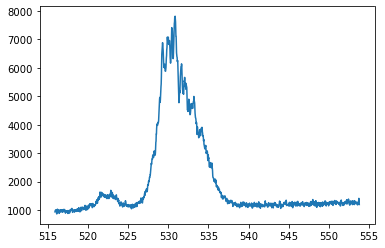

In [11]:
plt.plot(energy, vik[2])

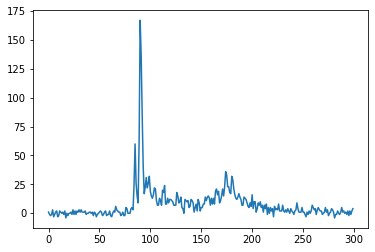

In [12]:
plt.plot(-pes_data["channel_1_A"][0,31400:31700])

Now, let's fit the model:

In [13]:
n_test = 10 # exclude some trains to validate the training

In [14]:
# exclude the last n_test train IDs so we can use them for validation later
pes_train = {ch: pes_data[ch][:-n_test, :] for ch in pes_data.keys()}
vik_train = vik[:-n_test, :]
xgm_train = xgm[:-n_test,:]

model = Model(channels=channels)
model.fit(pes_train,
          vik_train,
          np.broadcast_to(energy, (vik_train.shape[0], vik_train.shape[-1])),
          pulse_energy=xgm_train)

Checking data quality in high-resolution data.
Finding region-of-interest
Excluding outliers
Selected 585 of 650 samples.
Fitting PCA on low-resolution data.
Using 585 comp. for PES PCA.
Fitting PCA on high-resolution data.
Using 20 comp. for grating spec. PCA.
Fitting outlier detection
Fitting model.
Calculate PCA unc. on high-resolution data.
Calculate transfer function
Resolution = 0.21 eV, S/R = 31.65
Calculate PCA on channel_1_A
Calculate PCA on channel_1_B
Calculate PCA on channel_1_C
Calculate PCA on channel_1_D
Calculate PCA on channel_2_A
Calculate PCA on channel_2_B
Calculate PCA on channel_2_C
Calculate PCA on channel_2_D
Calculate PCA on channel_3_A
Calculate PCA on channel_3_B
Calculate PCA on channel_3_C
Calculate PCA on channel_3_D
Calculate PCA on channel_4_A
Calculate PCA on channel_4_B
Calculate PCA on channel_4_C
Calculate PCA on channel_4_D
End of fit.


array([[[ 941.7556739 ,  960.7466906 ,  985.17017035, ...,
         1429.04684533, 1345.94695049, 1329.10718964]],

       [[1078.21605126, 1053.65423777, 1074.17111375, ...,
         1328.01665665, 1424.27242218, 1363.57039719]],

       [[ 935.14152295,  949.06555853,  981.37960431, ...,
         1409.16571326, 1329.469592  , 1194.42605757]],

       ...,

       [[1045.26133427, 1036.86744532, 1038.0833779 , ...,
         1217.20061892, 1229.75449766, 1324.46568021]],

       [[ 963.99623994,  917.30989815,  951.01639677, ...,
         1184.09118495, 1213.19978068, 1246.6430387 ]],

       [[ 971.19057956,  997.87876607, 1054.56073639, ...,
         1326.4308076 , 1305.95261086, 1344.42417077]]])

The resolution of the Virtual Spectrometer relative to the Viking has also been estimated (in eV):

In [15]:
model.resolution

0.20807378189472026

We can look at the Virtual Spectrometer to Viking response function as well.

Text(0, 0.5, 'Intensity [a.u.]')

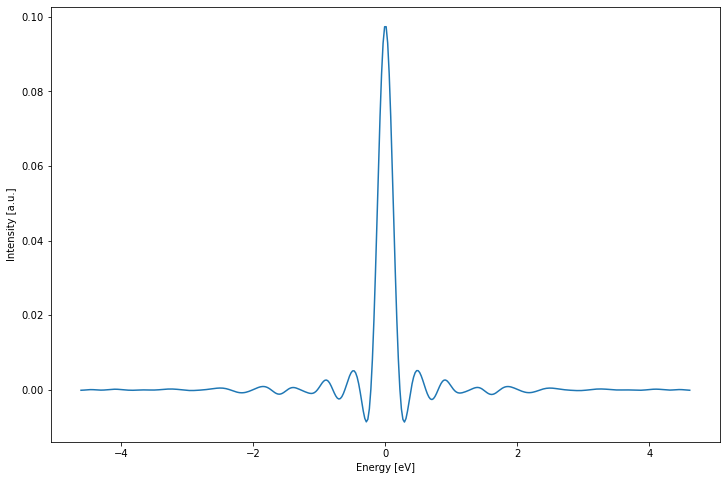

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(model.impulse_axis, model.impulse_response)
plt.xlabel('Energy [eV]')
plt.ylabel('Intensity [a.u.]')

## Save model

In [17]:
model.save("VS_p5576_viking.joblib")

## Apply model in data not used in training

In [18]:
pes_test = {ch: pes_data[ch][n_test:, :] for ch in pes_data.keys()}
vik_test = vik[n_test:, :]
xgm_test = xgm[n_test:,:]

In [19]:
vs_test = model.predict(pes_test, pulse_energy=xgm_test)

In [20]:
vs_test["energy"] = model.get_energy_values()

Add Viking in the same dictionary for convinience. In practice this would not be done in inference: it is done here to validate the results obtained.

In [21]:
vs_test["viking"] = vik_test

Now we can plot it:

In [22]:
def plot(data, i):
    """Plot prediction and expectation."""
    from matplotlib.gridspec import GridSpec
    fig = plt.figure(figsize=(24, 8))
    gs = GridSpec(1, 2)
    ax = fig.add_subplot(gs[0, 0])
    ax.plot(data["energy"], data["viking"][i], c='b', lw=3, label="Viking")
    ax.plot(data["energy"], data["expected"][i,0], c='r', ls='--', lw=3, label="Prediction")
    ax.fill_between(data["energy"],
                    data["expected"][i,0] - data["residual"][i,0],
                    data["expected"][i,0] + data["residual"][i,0],
                    facecolor='gold', alpha=0.5, label="68% unc.")
    ax.legend(frameon=False, borderaxespad=0, loc='upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(
            xlabel="Photon energy [eV]",
            ylabel="Intensity [a.u.]",
            title="Comparing with the original Viking",
    )
    ax = fig.add_subplot(gs[0, 1])
    viking_smooth = fftconvolve(data["viking"][i], model.impulse_response, mode="same")
    ax.plot(data["energy"], viking_smooth, c='b', lw=3, label="Viking (convolved to VS resolution)")
    ax.plot(data["energy"], data["expected"][i,0], c='r', ls='--', lw=3, label="Prediction")
    ax.fill_between(data["energy"],
                    data["expected"][i,0] - data["residual"][i,0],
                    data["expected"][i,0] + data["residual"][i,0],
                    facecolor='gold', alpha=0.5, label="68% unc.")
    ax.legend(frameon=False, borderaxespad=0, loc='upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(
            xlabel="Photon energy [eV]",
            ylabel="Intensity [a.u.]",
            title="Same, with smoothened Viking",
    )
    plt.show()

These are the last 10 train IDs, which were not used in training.

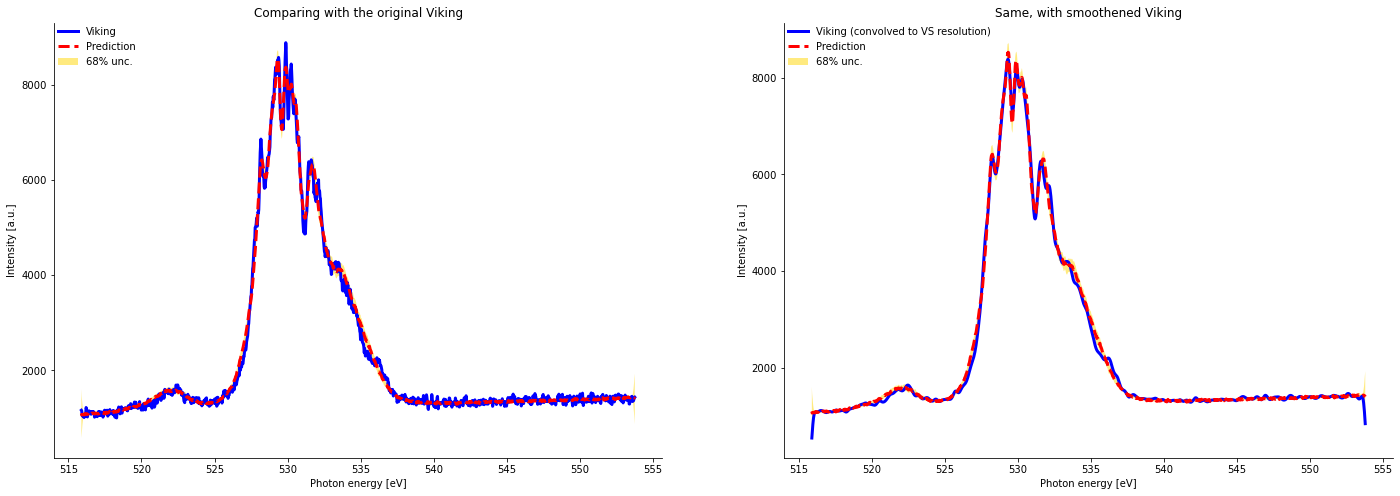

In [23]:
plot(vs_test, 0)

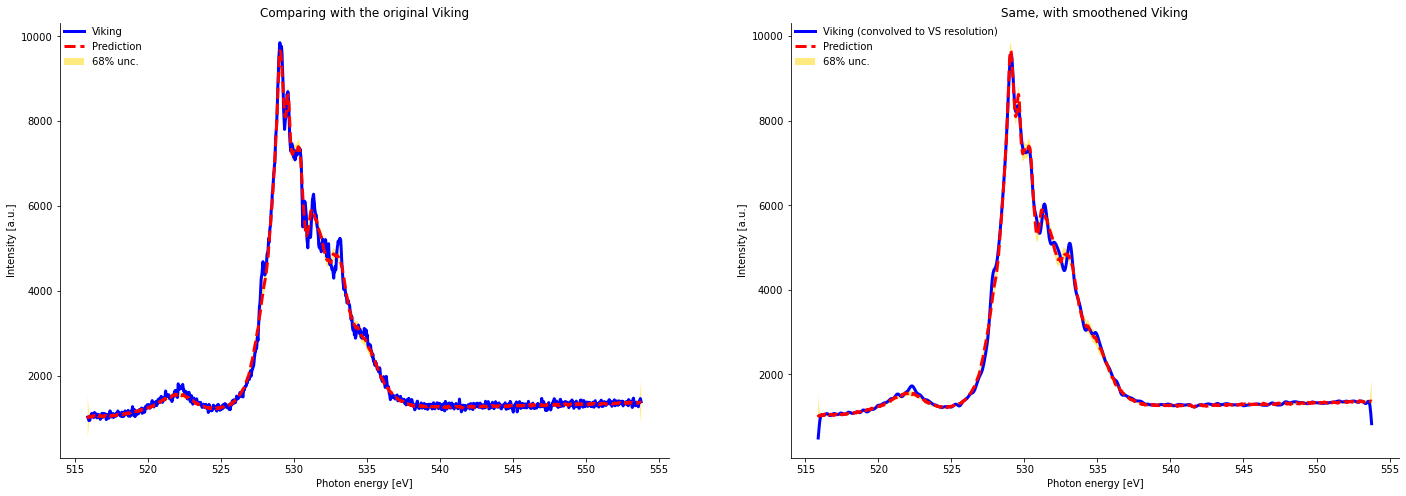

In [24]:
plot(vs_test, 1)

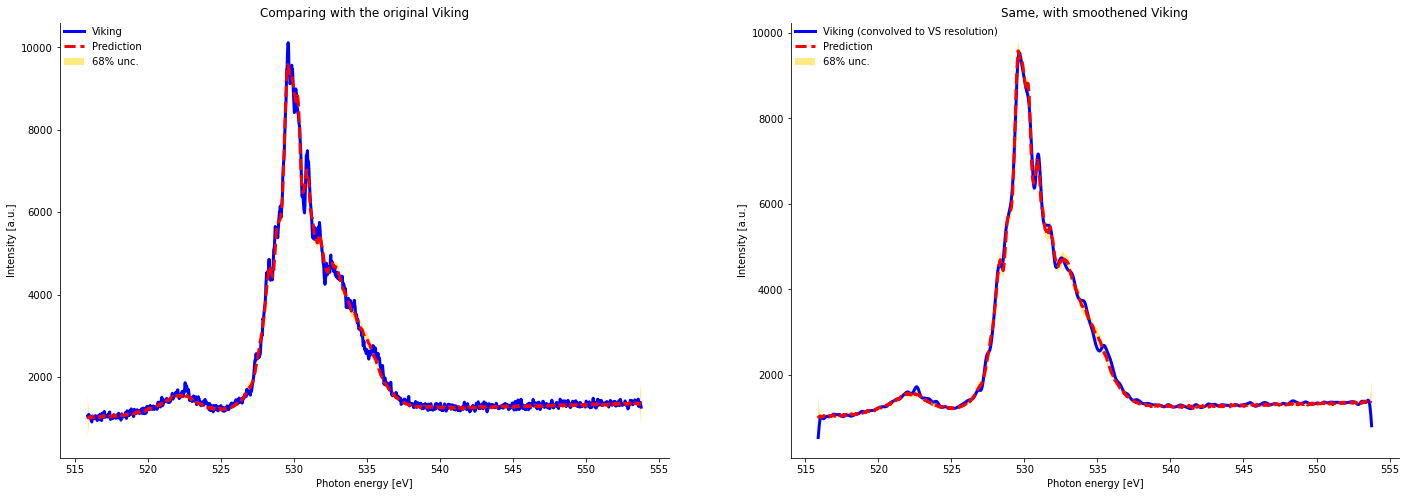

In [25]:
plot(vs_test, 2)

## Apply it in new data without Viking

Retrieve PES and XGM data into the expected format.


In [28]:
runTest = 321

# bunch pattern table
field_bpt = [
             {'bunchPatternTable': {'source': 'SA3_BR_UTC/TSYS/TIMESERVER:outputBunchPattern',
                                    'key': 'data.bunchPatternTable',
                                    'dim': ['pulses'],
                                   },
              },
             ]

In [29]:
from pes_to_spec.model import Model
model = Model.load("VS_p5576_viking.joblib")

In [30]:
_, data_inf = tb.load(proposal, runTest, fields + field_bpt)

# transform PES data into the format expected
pes_data_inf = {k: da.from_array(data_inf[item].to_numpy())
            for k, item in pes_map.items() if item in data_inf}
xgm_inf = data_inf.XTD10_SA3.to_numpy()

# assume it does not change:
bpt_inf = data_inf.bunchPatternTable.isel(trainId=0).to_numpy()

Source SA3_BR_UTC/TSYS/TIMESERVER:outputBunchPattern not found in run. Skipping!


Source SA3_BR_UTC/TSYS/TIMESERVER:outputBunchPattern not found in run. Skipping!


In [31]:
# assume the same bunch pattern structure throughout the run!
fel_pos = indices_at_sase(bpt_inf, sase=3)
fel_pos -= fel_pos[0]
freq_ratio = {ch: 220 for ch in channels}
sample_pos = {ch: fel_pos * 2 * freq for ch, freq in freq_ratio.items()}
pulse_spacing = sample_pos

In [32]:
pulse_spacing

{'channel_1_A': array([     0,  14080,  28160,  42240,  56320,  70400,  84480,  98560,
        112640, 126720, 140800, 154880, 168960, 183040, 197120, 211200,
        225280, 239360, 253440, 267520, 281600, 295680, 309760, 323840,
        337920, 352000, 366080, 380160, 394240, 408320, 422400, 436480,
        450560, 464640, 478720, 492800, 506880, 520960, 535040, 549120,
        563200, 577280, 591360]),
 'channel_1_B': array([     0,  14080,  28160,  42240,  56320,  70400,  84480,  98560,
        112640, 126720, 140800, 154880, 168960, 183040, 197120, 211200,
        225280, 239360, 253440, 267520, 281600, 295680, 309760, 323840,
        337920, 352000, 366080, 380160, 394240, 408320, 422400, 436480,
        450560, 464640, 478720, 492800, 506880, 520960, 535040, 549120,
        563200, 577280, 591360]),
 'channel_1_C': array([     0,  14080,  28160,  42240,  56320,  70400,  84480,  98560,
        112640, 126720, 140800, 154880, 168960, 183040, 197120, 211200,
        225280, 239360,

If there are multiple pulses in a train, the pulse spacing above tells us about how many samples there are between them. The first item in the list above is always zero, as the task of identifying the position of the first pulse is taken care through the Virtual Spectrometer itself.

Now we can do the prediction itself. To get each pulse in a train, the `pulse_spacing` should be specified as the one above.

In [33]:
vs_inf = model.predict(pes_data_inf, pulse_energy=xgm_inf, pulse_spacing=pulse_spacing)

In [34]:
vs_inf["energy"] = model.get_energy_values()

Now we can plot it:

In [37]:
def plot_new(data, i, pulse=0):
    """Plot prediction and expectation."""
    from matplotlib.gridspec import GridSpec
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax.plot(data["energy"], data["expected"][i,pulse], c='r', ls='--', lw=3, label="Prediction")
    ax.fill_between(data["energy"],
                    data["expected"][i,pulse] - data["residual"][i,pulse],
                    data["expected"][i,pulse] + data["residual"][i,pulse],
                    facecolor='gold', alpha=0.5, label="68% unc.")
    ax.legend(frameon=False, borderaxespad=0, loc='upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(
            xlabel="Photon energy [eV]",
            ylabel="Intensity [a.u.]",
            title="",
    )
    plt.show()

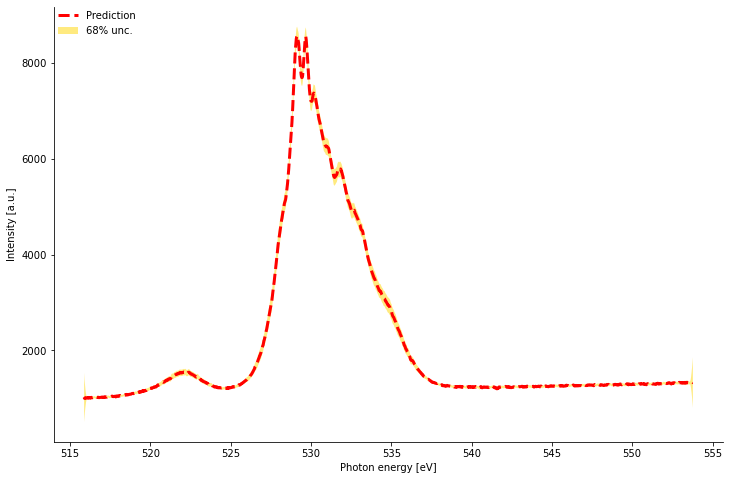

In [41]:
plot_new(vs_inf, 0, pulse=2)